In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, copy
import datetime

Au cour de ce notebook nous manipulerons essentiellement 3 jeux de données. 
- Données mesurées par le wattmetre
- Données mesurées par aipowermeter
- Temps de démarrage de chaque épochs

In [4]:

epoch = np.loadtxt('data/ts.csv')

In [11]:
# useful function

def consommation(df, ts='#timestamp', w='#activepow1', total=False):
    """compute joule conversion on wattmetre output

    Args:
        df (pandas.DataFrame): wattmetre output dataframe
        total (bool, optional): print total. Defaults to False.

    Returns:
        [type]: [description]
    """
    integral_2_value = (df[w]*2)[:-1] + df[w].diff()[1:].tolist()
    diff_timestamp = df[ts].diff()[1:]
    diff_timestamp.index = range(len(diff_timestamp))
    
    df_j = pd.DataFrame({'ts': df[ts][1:].tolist(), 'j': diff_timestamp*integral_2_value/2})
    
    return sum(diff_timestamp*integral_2_value/2) if total else df_j
    
def get_value(power_metrics=None, metrics=None, debug=False):
    """travel across dictionary

    Args:
        power_metrics (dict): dictionnary. Defaults to None.
        metrics (list): keys way to get the target value. Defaults to None.
        debug (bool): print running step. Defaults to False.
        
    Returns:
        float: return the target value 
    """
    for metric in metrics:
        if debug:
            print(f'running on {metric}')
        if metric == 'pid':
            # if not exist then return error -> return 0
            try:
                power_metrics = sum(list(power_metrics.values()))
            except IndexError:
                print("no metrics on GPU found")
                power_metrics = 0
        elif metric == 'sm':
            power_metrics = sum(s.get('sm') for s in power_metrics)
        elif metric in power_metrics.keys(): 
            power_metrics = power_metrics.get(metric)
        else:
            return 0

    return power_metrics    

def integrate(date, watt, convert_date=True):
    """integrate x: date, y: watt

    Args:
        date (list): list of date
        watt (list): list of watt

    Raises:
        ValueError: [description]

    Returns:
        float: estimated joule metric
    """
    v = []
    if len(date) != len(watt):
        raise ValueError('not the same length')
    for i in range(len(watt)-1):
        x1 = datetime.datetime.fromisoformat(date[i]).timestamp() if convert_date else date[i]
        x2 = datetime.datetime.fromisoformat(date[i+1]).timestamp() if convert_date else date[i+1]
        y1 = watt[i]
        y2 = watt[i+1]
        v.append((x2-x1)*(y2+y1)/2)
    return v


<hr>

# WattMetre.viz

<hr>

Pipeline : 
1. Preprocessing
   - Suppression des colonnes inutiles
   - Suppression des nans et des valeurs négatives
2. Visualisation de la puissance
3. Visualisation de l'énergie
   - Conversion en Joule
   - Regroupement par deltaT comparable à ceux de power_metrics.json (~2s)

## 1. Preprocessing

In [6]:
wat_proc = pd.read_csv('data/sgd.log')
print(f'df shape: {wat_proc.shape}')

df shape: (216229, 17)


/home/matthieu-inspiron/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
print(
    f'''
Quantile des watt mesurés par le wattmetre :

{wat_proc['#activepow1'].quantile([(i+1)/10 for i in range(10)])}
    '''
)    


Quantile des watt mesurés par le wattmetre :

0.1     59.7
0.2     65.8
0.3    291.6
0.4    316.7
0.5    350.4
0.6    394.6
0.7    439.6
0.8    481.0
0.9    516.2
1.0    754.2
Name: #activepow1, dtype: float64
    


In [8]:
wat_proc.head()

,#timestamp,#frame_is_ok,#U1,#U2,#U3,#current1,#activepow1,#current2,#activepow2,#current3,#activepow3,#current4,#activepow4,#current5,#activepow5,#current6,#activepow6
0,1.640278e+09,True,232.1,0.0,0.0,0.4,54.2,0.1,22.5,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
1,1.640278e+09,True,232.9,0.0,0.0,0.4,54.6,0.1,22.6,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,1.640278e+09,True,232.9,0.0,0.0,0.4,54.6,0.1,22.6,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
3,1.640278e+09,True,232.9,0.0,0.0,0.4,58.4,0.1,16.8,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
4,1.640278e+09,True,232.9,0.0,0.0,0.4,58.4,0.1,16.8,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


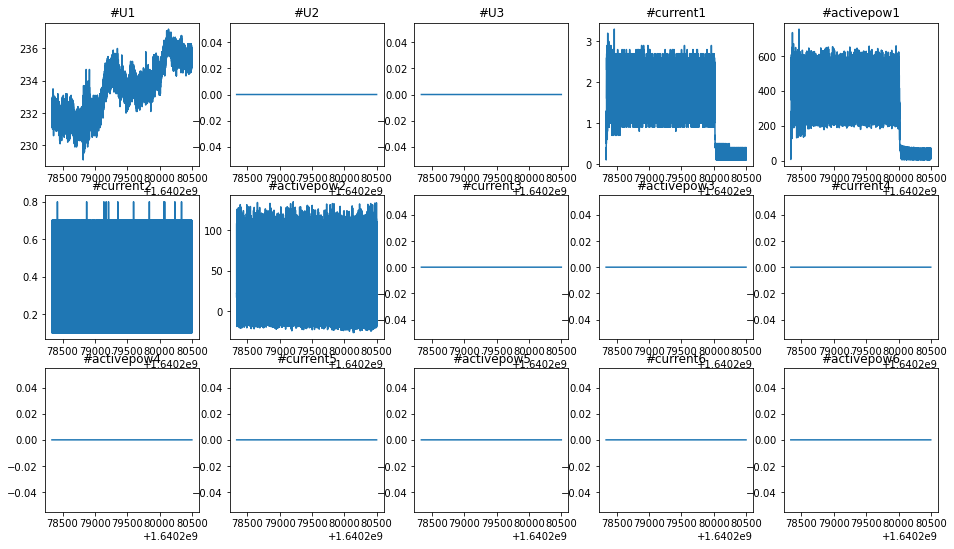

In [9]:
# vue d'ensemble
plt.figure(figsize=(16,9))
for i, col in enumerate(wat_proc.columns[2:]):
    plt.subplot(3,5,i+1)
    plt.title(col)
    plt.plot(wat_proc['#timestamp'], wat_proc[col])
    
plt.show()

In [21]:
# focus sur les colonnes qui nous intéresse
ansa = wat_proc[['#timestamp', '#activepow1']]

In [22]:
# suppression des nans
ansa = ansa.dropna()

# conso pour les données en J
conso = consommation(ansa)

# watt pour les données en W
watt = copy.copy(ansa)
watt.columns = ['ts', 'w']

print(f'Consommation totale mesurée par le wattmetre : {consommation(ansa, total=True):,.2f} Joules')

Consommation totale mesurée par le wattmetre : 703,744.83 Joules


Récupération des données power_metrics.json

On veut passer d'une structure 
```
{date {mesure,mesure,mesure}}
{date {mesure,mesure,mesure}}
{date {mesure,mesure,mesure}}
```
à
```
date,mesure,mesure,mesure
date,mesure,mesure,mesure
date,mesure,mesure,mesure
```

In [23]:
path='data/power_metrics.json'
with open(path, 'r') as f:
    metrics = [json.loads(line) for line in f]
    

In [24]:
intel_power_watt = [get_value(power_metrics=metric, metrics=['metrics', 'cpu', 'intel_power']) for metric in metrics]
total_cpu_power = [get_value(power_metrics=metric, metrics=['metrics', 'cpu', 'total_cpu_power']) for metric in metrics]
nvidia_draw_absolute = [get_value(power_metrics=metric, metrics=['metrics', 'gpu', 'nvidia_draw_absolute']) for metric in metrics]
nvidia_estimated_attributable_power_draw = [get_value(power_metrics=metric, metrics=['metrics', 'gpu', 'nvidia_estimated_attributable_power_draw']) for metric in metrics]
mem_use_abs = [get_value(power_metrics=metric, metrics=['metrics', 'cpu', 'per_process_mem_use_abs', 'pid']) for metric in metrics]
per_gpu_attributable_mem_use = [get_value(power_metrics=metric, metrics=['metrics', 'gpu', 'per_gpu_attributable_mem_use', '0', 'pid']) for metric in metrics]
sm = [get_value(power_metrics=metric, metrics=['metrics', 'gpu', 'per_gpu_average_estimated_utilization_absolute', 'sm']) for metric in metrics]
date = [get_value(power_metrics=metric, metrics=['date']) for metric in metrics]

## 2.Comparaison des watts

Comparaison des watts mesurés par AIpowermeter et le wattmetre :


In [25]:
aipowermeter_watt = list(map(lambda x,y: x+y, nvidia_estimated_attributable_power_draw, intel_power_watt))

In [26]:
print(
    f'''
min: {min(date)}
max: {max(date)}
min: {min(ansa['#timestamp'])}
max: {max(ansa['#timestamp'])}
    '''
)


min: 2021-12-23 17:52:25.100263
max: 2021-12-23 18:20:12.017487
min: 1640278335.810222
max: 1640280497.6206467
    


Si les dates retournées ci dessus ne sont pas toutes les 2 au format timestamp alors une conversion date to timestamp nécessaire.

In [27]:
date_ts = list(map(lambda x: pd.Timestamp(x).timestamp()-3600, date))
watt = watt[watt.ts<=max(date_ts)]
mean_average_watt = watt.w.rolling(200, center=True).mean()

Nous pouvons voir sur la cellule ci dessous que le temps de prise de mesure de aipowermeter n'est pas constant. Il varie entre 2 et 3 secondes.

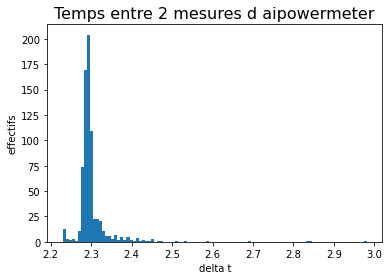

In [31]:
plt.title('Temps entre 2 mesures d aipowermeter', fontsize=16)
plt.hist(pd.Series(date_ts).diff(), bins=100)
plt.ylabel('effectifs')
plt.xlabel('delta t')
plt.show()

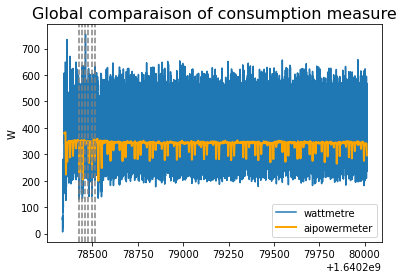

In [28]:
# fig, ax = plt.subplots(figsize=(16,9))
plt.title('Global comparaison of consumption measure', fontsize=16)
plt.plot(watt.ts, watt.w, label='wattmetre')
# plt.plot(watt.ts, mean_average_watt, label='MA wattmetre', linewidth=2, color='#000062')
plt.plot(date_ts, aipowermeter_watt, label='aipowermeter', linewidth=2, color="orange")
plt.ylabel('W')
for i in range(5,11):
    plt.axvline(x=epoch[i], color='grey', linestyle='--')
plt.legend()
plt.savefig('data/images/watt_global.png')
plt.show()

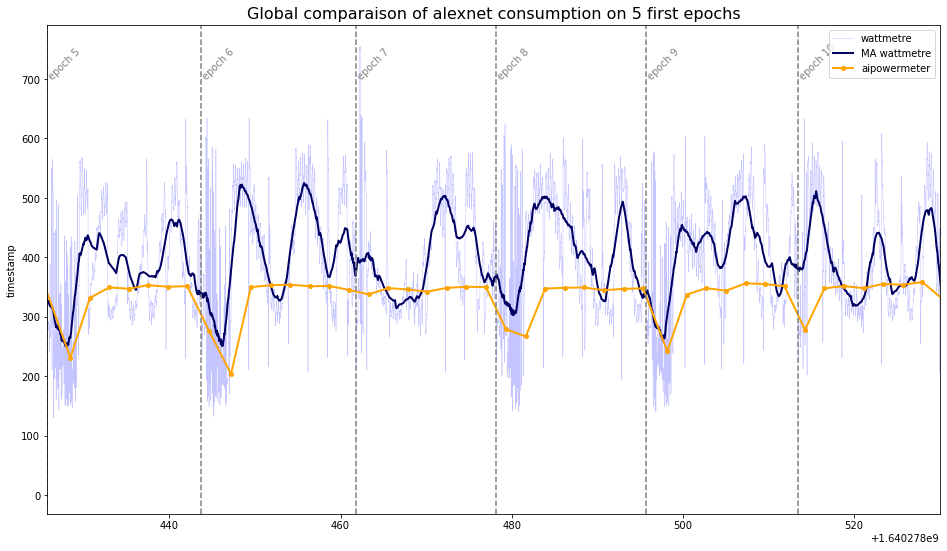

In [29]:
lim = 5

fig, ax = plt.subplots(figsize=(16,9))

plt.title('Global comparaison of alexnet consumption on 5 first epochs', fontsize=16)
plt.plot(watt.ts, watt.w, label='wattmetre', linewidth=0.5, color="#c4c4ff")
plt.plot(watt.ts, mean_average_watt, label='MA wattmetre', linewidth=2, color='#000062')
plt.plot(date_ts, aipowermeter_watt, label='aipowermeter', linewidth=2, marker="o", ms=4, color="orange")
plt.ylabel('W')
plt.ylabel('timestamp')
for i in range(lim, lim+6):
    plt.axvline(x=epoch[i], color='grey', linestyle='--')
    ax.text(epoch[i], 700, f'epoch {i}', color='grey', rotation=45)
plt.xlim((epoch[lim], epoch[lim+6]))
plt.legend()
plt.savefig('data/images/watt_epoch.png')
plt.show()

Le plot ci dessus permet de visualiser les données mesurées par aipowermeter et celles du wattmetre (lissée sur une fenêtre de 200).

L'observation des 5 premiers épochs nous permet d'observer une descente de la consommation entre chaque epochs. La mesure prise par le wattmetre nous montre que la consomation n'est pas constante au cours d'un epoch contrairement à ce qui pourrait être soupçonné en se basant seulement sur les données d'aipowermeter. 



## 3. Visualisation de l'énergie

In [38]:
# le retrait de la première valeur est nécessaire car suite à l'intégration des données en watt, nous raisonnons en integrals et perdons donc une donnée.
df = pd.DataFrame({
    'date': date[:-1],
    'date_ts': date_ts[:-1],
    'intel_power': integrate(date=date, watt=intel_power_watt),
    'total_cpu_power': integrate(date=date, watt=total_cpu_power),
    'nvidia_draw_absolute': integrate(date=date, watt=nvidia_draw_absolute), 
    'nvidia_estimated_attributable_power_draw': integrate(date=date, watt=nvidia_estimated_attributable_power_draw),
    'mem_use_abs': mem_use_abs[:-1],
    'per_gpu_attributable_mem_use': per_gpu_attributable_mem_use[:-1],
    'sm': sm[:-1],
    'aipowermeter_watt': aipowermeter_watt[:-1]
})
df['total_power'] = df.intel_power + df.nvidia_draw_absolute

Objectif : Coller les chiffres de la consommation aux date les plus proches

In [39]:
print(f'Exemple du nombre de mesures entre 2 dates de aipowermeter dans la conso du wattmetre : {conso.ts[(conso.ts>=df.date_ts[0]) & (conso.ts<=df.date_ts[1])].shape[0]}')

Exemple du nombre de mesures entre 2 dates de aipowermeter dans la conso du wattmetre : 225


225 valeurs du wattmetre contre 2 aipowermeter. Faire des regroupements pour diviser cette quantité par 10 et voir si l'élévation de puissance est plus distincte

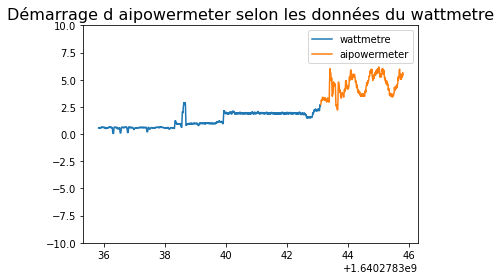

In [42]:
plt.title('Démarrage d aipowermeter selon les données du wattmetre', fontsize=16)
plt.plot(conso.ts[:1000][conso.ts[:1000]<df.date_ts[0]-2], conso.j[:1000][conso.ts[:1000]<df.date_ts[0]-2], label='wattmetre')
plt.plot(conso.ts[:1000][conso.ts[:1000]>=df.date_ts[0]-2], conso.j[:1000][conso.ts[:1000]>=df.date_ts[0]-2], label='aipowermeter')
plt.ylim((-10,10))
plt.legend()
plt.show()

**Procédure :** \
*Perte de précision avec cette méthode, mais + simple et suffisant pour la surveillance de consommation dans notre cas*
- Arrondir à la seconde (la plus proche) chaque timestamp 
- Faire une somme pour regrouper chaque valeur d'énergie


In [43]:
conso.ts = conso.ts.round().astype(int)
df.date_ts = df.date_ts.round().astype(int)

In [46]:
uconso = conso.groupby(by='ts').sum()
udf = df.groupby(by='date_ts').sum()
udf['j'] = [0]+integrate(udf.index.tolist(), udf.aipowermeter_watt.tolist(), False)

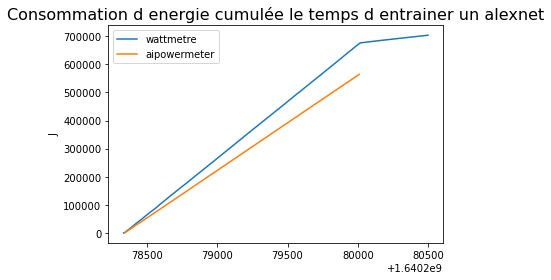

In [49]:
plt.title('Consommation d energie cumulée le temps d entrainer un alexnet', fontsize=16)
plt.plot(uconso.index, uconso.j.cumsum(), label='wattmetre')
plt.plot(udf.index, udf.total_power.cumsum(), label='aipowermeter')
plt.legend()
plt.ylabel('J')
plt.show()

Le graphe ci dessus nous montre l'évolution de l'énergie consommée depuis le démarrage de l'entrainement d'alexnet. L'écart se creuse avec le temps, cela s'explique notamment pas un écart constant entre la mesure de puissance de aipowermeter et du wattmetre. Cumulés, l'écart s'agrandit au fur et à mesure du temps.

Voyons maintenant l'évolution de la consommation d'énergie par intervale de mesure d'aipowermeter (~2s).

In [50]:
ts = copy.copy(uconso.index.tolist())
ts = list(filter(lambda x: x >= udf.index[0], ts))

In [51]:
cumule = []
for i in udf.index:
    ts_reg = ts[:ts.index(i)]
    cumule.append(uconso.j[ts_reg].sum())
    [ts.remove(t) for t in ts_reg]
    
    

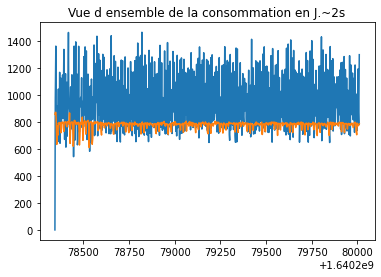

In [54]:
plt.title('Vue d ensemble de la consommation en J.~2s')
plt.plot(udf.index, cumule)
plt.plot(udf.index, udf.total_power)
plt.show()

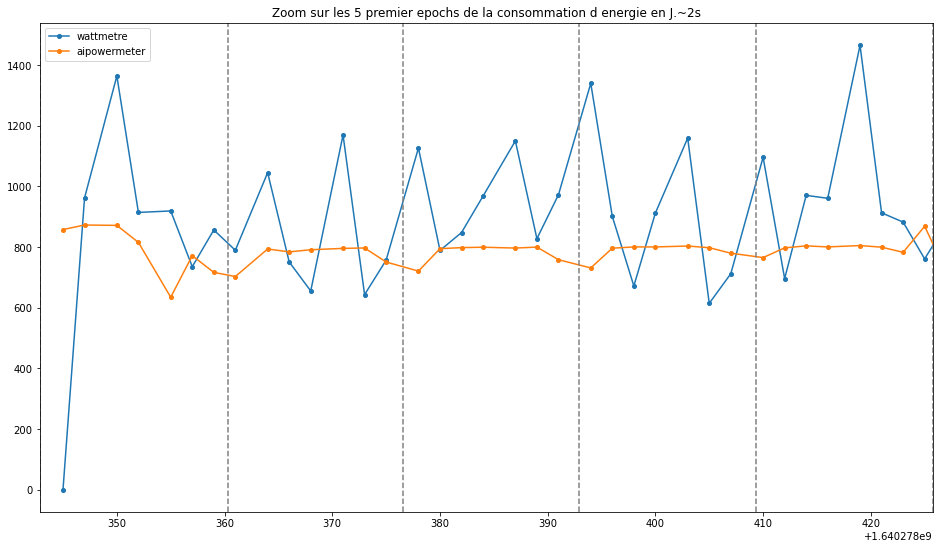

In [56]:
plt.figure(figsize=(16,9))
plt.title('Zoom sur les 5 premier epochs de la consommation d energie en J.~2s')
plt.plot(udf.index, cumule, label='wattmetre', marker="o", ms=4)
plt.plot(udf.index, udf.total_power, label='aipowermeter', marker="o", ms=4)
for i in range(6):
    plt.axvline(x=epoch[i], color='grey', linestyle='--')
plt.xlim((epoch[0], epoch[5]))
plt.legend()
plt.show()

In [58]:
print(
    f'''
Comparaison consommation total sur l'entrainement:
    wattmetre:      {sum(cumule):,.1f}    
    aipowermeter:   {sum(udf.total_power):,.1f}    
    
    '''
)



Comparaison consommation total sur l'entrainement:
    wattmetre:      672,576.2    
    aipowermeter:   564,534.1    
    
    
